<a href="https://colab.research.google.com/github/kniemi641/UC-MScA/blob/master/ML%20Homework%204%20-%20Random%20Forest%20with%20Grid%26Random%20Search%20hypertuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Homework 4

The purpose of this exercise is to create random-forest classifer models using data from the 'default of credit card clients.csv' file provided. One model is prepared using the default parameters from the sklearn library and the other uses the grid search method to iterate over a supplied dictionary of hyper-parameter values. 

## Packages & Variables

In [0]:
# Generic Packages
import pandas as pd
import numpy as np
import math
import os
from scipy import stats

# sklearn packages
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# Plotting Packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import seaborn as sns

# Utility stuff
import pickle
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive, files
drive.mount('/content/gdrive')

np.random.seed(235)

In [0]:
#GLOBAL & CONSTANTS
NUM = 4
INPUT_DATA_FILE = 'default of credit card clients.csv'

GD_CODE_DIR = '/content/gdrive/My Drive/Code/uchicago/'
SUBJECT_DIR = 'Machine Learning & Predictive Analytics/'
DATA_DIR = 'data/'
MODEL_DIR = 'models/'
LOGS_DIR = 'logs/'
HOMEWORK_DIR = 'Homework {}/'.format(NUM)
NOTEBOOK_NAME = 'Homework {}.ipynb'.format(NUM)

MAIN_PATH = os.path.join(GD_CODE_DIR
                        ,SUBJECT_DIR
                        ,HOMEWORK_DIR)

INPUT_FILE = os.path.join(MAIN_PATH
                          ,DATA_DIR
                          ,INPUT_DATA_FILE)

NOTEBOOK_FILE = os.path.join(MAIN_PATH
                            ,NOTEBOOK_NAME)

MODEL_EXPORT_PATH = os.path.join(MAIN_PATH
                                ,MODEL_DIR)

LOG_PATH = os.path.join(MAIN_PATH
                       ,LOGS_DIR)





## Exploratory Analysis

The data is imported, the Identifier column 'ID' is dropped, along with observations with 'NaN' values

In [3]:
credit_data = pd.read_csv(INPUT_FILE)
credit_df = pd.DataFrame(credit_data)

columns = credit_df.columns.get_values()
credit_df.columns=columns

credit_df.drop(columns = ['ID'], inplace=True)
credit_df.replace(["NaN", 'NaT'], np.nan, inplace =True)
credit_df.dropna(how='any', axis = 0, inplace=True)

print('Columns: {}'.format(columns))
print('\n Highlevel Stats of data: {}'.format(credit_df.describe()))
print('\n Shape of Data: {}'.format(credit_df.shape))

Columns: ['ID' 'LIMIT_BAL' 'SEX' 'EDUCATION' 'MARRIAGE' 'AGE' 'PAY_0' 'PAY_2'
 'PAY_3' 'PAY_4' 'PAY_5' 'PAY_6' 'BILL_AMT1' 'BILL_AMT2' 'BILL_AMT3'
 'BILL_AMT4' 'BILL_AMT5' 'BILL_AMT6' 'PAY_AMT1' 'PAY_AMT2' 'PAY_AMT3'
 'PAY_AMT4' 'PAY_AMT5' 'PAY_AMT6' 'default payment next month']

 Highlevel Stats of data:             LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.853133      1.551867     35.485500   
std     129747.661567      0.489129      0.790349      0.521970      9.217904   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.0

The response will be the categorical variable 'default payment next month' and the remaining columns will be used as predictors.

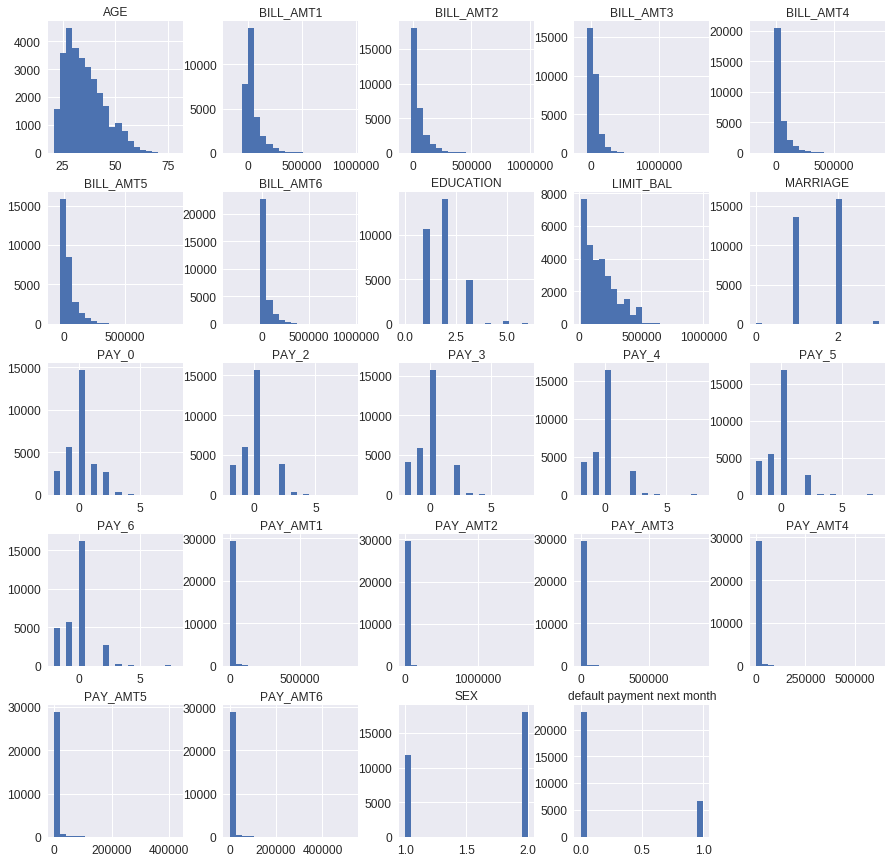

In [4]:
predictors = credit_df.columns[credit_df.columns != 'default payment next month']
response = credit_df.columns[(credit_df.columns == 'default payment next month')]

def plot_df_hists(df, X_names, y_names, b = 50):  
  df.hist(bins=b, figsize=(15,15))
  plt.show()
  
plot_df_hists(credit_df, predictors.ravel(), response, 20)

The data is split into train and test with a ratio of 0.3. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(credit_df[predictors]
                                                    , credit_df[response]
                                                    , test_size = .3
                                                    , random_state = 235)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print('\nShape of X Train: {}'.format(X_train.shape))
print('\nShape of X Test: {}'.format(X_test.shape))
print('\nShape of y Train: {}'.format(y_train.shape))
print('\nShape of y Train: {}'.format(y_test.shape))


Shape of X Train: (21000, 23)

Shape of X Test: (9000, 23)

Shape of y Train: (21000,)

Shape of y Train: (9000,)


## Random Forest with sklearn defaults

The RandomForestClassifier model, with the default hyper-parameters values, is used to fit the model to the training data. The default sklearn hyper-parameters (not all, just the ones of interest for the assignement) are max_features = n_features, max_depth = None, and n_estimators=100.

The model is scored using the mean accuracy for each class, the classification report and confusion matrix are shown below. 

In [6]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)

yhat_rf_train = rnd_clf.predict(X_train)
yhat_rf_test = rnd_clf.predict(X_test)

yhat_rf_train_prob = rnd_clf.predict_proba(X_train)
yhat_rf_test_prob = rnd_clf.predict_proba(X_test)

rnd_clf_score_train = rnd_clf.score(X_train, y_train)
rnd_clf_score_test = rnd_clf.score(X_test, y_test)

rnd_clf_conf_mx = confusion_matrix(y_test, yhat_rf_test)
rnd_clf_class_report = (classification_report(y_test, yhat_rf_test))

print('Model Score Train: {}'.format(round(rnd_clf_score_train, 4)))
print('Model Score Test: {}'.format(round(rnd_clf_score_test, 4)))
print('\nConfusion Matrix:\n{}'.format(rnd_clf_conf_mx))
print('\nClassification Report\n{}'.format(rnd_clf_class_report))

Model Score Train: 0.9808
Model Score Test: 0.8037

Confusion Matrix:
[[6606  378]
 [1389  627]]

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      6984
           1       0.62      0.31      0.42      2016

   micro avg       0.80      0.80      0.80      9000
   macro avg       0.73      0.63      0.65      9000
weighted avg       0.78      0.80      0.78      9000



The model is very overfit, as there is a large difference between the mean accuracy scores of the train and test data. The difference between the recall scores between the two classes is quite large as well. This indicates the model is predicting actual positives for the '0' class very well, and very poor for class '1'. This makes intuitive sense as the dataset is unbalanced, with much more '0' observations (no defaults). 

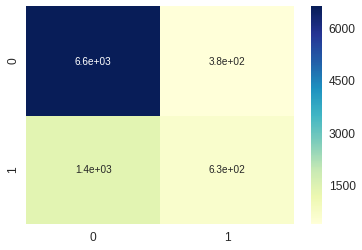

In [7]:
def make_heat_map(matrix):
    sns.heatmap(  matrix
                , annot=True
                , annot_kws={"Size" : 10}
                , cmap="YlGnBu")
    plt.figure(figsize=(10,10))
    plt.show()
    
make_heat_map(rnd_clf_conf_mx)

Next the ROC curve is constructed which is the true positive rate versus the false positive rate. The area under the curve, 'auroc', is calculated, which represents how well the model performs over all cut-off probability values. For reference, a model using a perfectly random coin would have an auroc 0.5 .

Area Under the ROC: 0.7307


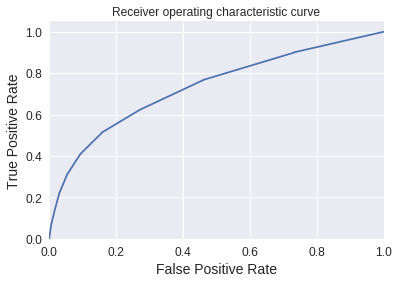

In [8]:
rnd_clf_aucroc = roc_auc_score(y_test, yhat_rf_test_prob[:,1])
print('Area Under the ROC: {}'.format(round(rnd_clf_aucroc, 4)))

def create_roc_plot(y_test, y_hat_test_prob):
  # limit to probability for class = 1 
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(20):
      fpr[i], tpr[i], _ = roc_curve(y_test, y_hat_test_prob)
      roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure()
  plt.plot(fpr[1], tpr[1])
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.show()
  
create_roc_plot(y_test ,yhat_rf_test_prob[:,1])

The 'auroc' shows the model has much room for improvement. A better performing model would have a curve which skews heavily to the top left of the 1x1 box (resulting in more area).

Top 10 Feature ranking:
Predictor: PAY_0 (0.1073)
Predictor: AGE (0.0664)
Predictor: LIMIT_BAL (0.0581)
Predictor: PAY_5 (0.0319)
Predictor: PAY_2 (0.0262)
Predictor: PAY_3 (0.0248)
Predictor: PAY_4 (0.0211)
Predictor: EDUCATION (0.0207)
Predictor: MARRIAGE (0.0143)
Predictor: SEX (0.0124)


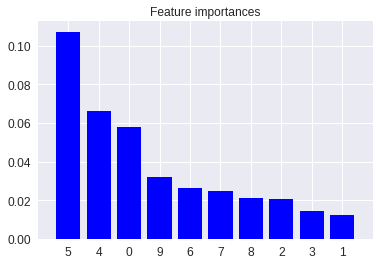

In [9]:
def get_top_importances(model, predictors, n=5):
  importances = model.feature_importances_[:n]
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Top {} Feature ranking:".format(n))

  for f in range(n):
      print("Predictor: {} ({})".format(predictors[indices[f]], round(importances[indices[f]], 4)))

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(n), importances[indices[:n]], color="b", align="center")
  plt.xticks(range(10), indices)
  plt.xlim([-1, n])
  plt.show()
  
get_top_importances(rnd_clf, predictors, 10)

The fifth feature is the most important, which is age in this case. This shows the model is constructing rules that are consistent with our business interpretation of the problem, age is the best predictor (for this model) at determining whether a user will default.

## GridSearchCV Random Forest

Next a model is generated using the GridSearchCV method, which uses k-fold cross validation to compare models created using a dictionary of hyper parameters, and chooses the best parameters. The n_estimators, max_features, max_depth and bootstrap indicator are chosen as hyper parameters to iterate over. A k value of 5 is used for the cross-fold validation, and the area under the reciever operating curve (roc_auc) is used as the accuracy metric.

In [10]:
#create a dictionary of parameters 
n_estimators = np.arange(500,1500,100)
max_feats = np.arange(2,8,2)
max_depth = np.arange(1,3,1)

param_grid = {
              'n_estimators':n_estimators
              ,'max_features':max_feats
              ,'max_depth':max_depth
              ,'random_state':[235]}

# create Random Forest model 
rf_obj=RandomForestClassifier()

# Create gridsearch object with various combinations of parameters
rf_Grid = GridSearchCV(rf_obj
                       ,param_grid
                       ,cv = 5
                       ,scoring = 'roc_auc'
                       ,refit = True
                       ,n_jobs=-1
                       ,verbose = 1)


rf_Grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 26.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': array([ 500,  600,  700,  800,  900, 1000, 1100, 1200, 1300, 1400]), 'max_features': array([2, 4, 6]), 'max_depth': array([1, 2]), 'random_state': [235]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [11]:
rnd_clf_grid = rf_Grid.best_estimator_
rnd_clf_grid_params = rf_Grid.best_params_
print('Best parameters from Grid Search {}'.format(rnd_clf_grid_params))

Best parameters from Grid Search {'max_depth': 2, 'max_features': 6, 'n_estimators': 800, 'random_state': 235}


The optimised random forest is created using from best estimator object, which is the model which uses the optimum  hyper-parameter values, shown above.

In [12]:
yhat_rf_grid_train = rnd_clf_grid.predict(X_train.values)
yhat_rf_grid_test = rnd_clf_grid.predict(X_test.values)

yhat_rf_grid_train_prob = rnd_clf_grid.predict_proba(X_train.values)
yhat_rf_grid_test_prob = rnd_clf_grid.predict_proba(X_test.values)

rf_grid_score_train = rnd_clf_grid.score(X_train, y_train)
rf_clf_grid_score = rnd_clf_grid.score(X_test, y_test)

class_report_grid = (classification_report(y_test, yhat_rf_grid_test))
conf_mx_grid = (confusion_matrix(y_test, yhat_rf_grid_test))

print('Model Score Train: {}'.format(round(rf_grid_score_train, 4)))
print('Model Score Test: {}'.format(round(rf_clf_grid_score, 4)))
print('\nConfusion Matrix\n{}'.format(conf_mx_grid))
print('\nClassification Report\n{}'.format(class_report_grid))

Model Score Train: 0.8089
Model Score Test: 0.8078

Confusion Matrix
[[6845  139]
 [1591  425]]

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      6984
           1       0.75      0.21      0.33      2016

   micro avg       0.81      0.81      0.81      9000
   macro avg       0.78      0.60      0.61      9000
weighted avg       0.80      0.81      0.76      9000



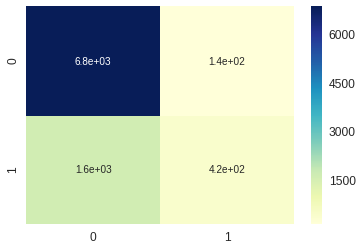

In [13]:
make_heat_map(conf_mx_grid)

The model score a small increase in performance all around.

Area Under the ROC: 0.7744


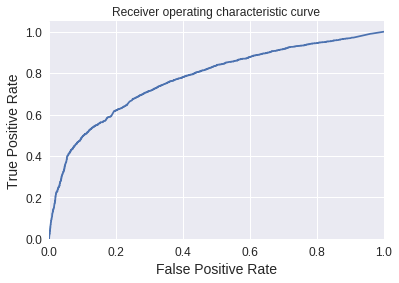

In [14]:
rf_grid_aucroc = roc_auc_score(y_test, yhat_rf_grid_test_prob[:,1])
print('Area Under the ROC: {}'.format(round(rf_grid_aucroc, 4)))

create_roc_plot(y_test, yhat_rf_grid_test_prob[:,1])

Again the increase in performance measured by the auc roc is minor but definitely an improvement.

Top 10 Feature ranking:
Predictor: PAY_0 (0.3626)
Predictor: PAY_2 (0.2311)
Predictor: PAY_3 (0.1259)
Predictor: PAY_4 (0.097)
Predictor: PAY_5 (0.0732)
Predictor: LIMIT_BAL (0.0137)
Predictor: EDUCATION (0.0001)
Predictor: AGE (0.0001)
Predictor: MARRIAGE (0.0)
Predictor: SEX (0.0)


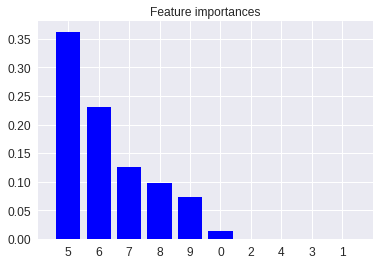

In [15]:
get_top_importances(rnd_clf_grid, predictors, n=10)

The feature ranking of the optimised model definitely has definitely improvement. The first 5 features are now heavily weighted in importance. An interesting conclusion is that it is really important to get the age and all of the payment variables for accurate predictions. In the model using the default parameters the importance is spread across the predictions.

Overall the model built using the gridsearch hyper-parameter does perform better, but not by much. Some of the optimal values are default parameters, not surprisingly, such as bootstrap. The max features is limited in the grid search but the n_estimators is much greater than the default. This 

{'max_features': 6, 'n_estimators': 500, 'bootstrap': True, 'max_depth': 6, 'random_state': 0}

## RandomSearchCV

Next the RandomSearchCV method is used to tune the Random Forest Model. The ranges and 

In [17]:
#create a dictionary of parameters 
n_estimators = np.arange(500,1500,10)
max_feats = np.arange(2,8,1)
max_depth = np.arange(1,3,1)
n_iter = 200

param_rand = {
              'n_estimators':n_estimators
              ,'max_features':max_feats
              ,'max_depth':max_depth
              ,'random_state':[235]
            }




# create Random Forest model 
rf_obj=RandomForestClassifier()

# Create gridsearch object with various combinations of parameters
rf_Rand = RandomizedSearchCV(rf_obj
                            , param_rand
                            , n_iter = n_iter
                            , cv = 3
                            , scoring = 'roc_auc'
                            , refit = True
                            , n_jobs=-1
                            , verbose = 1)

rf_Rand.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 37.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 49.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=200, n_jobs=-1,
          param_distributions={'n_estimators': array([ 500,  510, ..., 1480, 1490]), 'max_features': array([2, 3, 4, 5, 6, 7]), 'max_depth': array([1, 2]), 'random_state': [235]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=1)

In [18]:
rnd_clf_rand = rf_Rand.best_estimator_
rnd_clf_rand_params = rf_Rand.best_params_
print('Best parameters from Grid Search {}'.format(rnd_clf_rand_params))

Best parameters from Grid Search {'random_state': 235, 'n_estimators': 1100, 'max_features': 5, 'max_depth': 2}


In [21]:
yhat_rf_rand_train = rnd_clf_rand.predict(X_train.values)
yhat_rf_rand_test = rnd_clf_rand.predict(X_test.values)

yhat_rf_rand_train_prob = rnd_clf_rand.predict_proba(X_train.values)
yhat_rf_rand_test_prob = rnd_clf_rand.predict_proba(X_test.values)

rf_rand_score_train = rnd_clf_rand.score(X_train, y_train)
rf_clf_rad_score = rnd_clf_rand.score(X_test, y_test)

class_report_rand = (classification_report(y_test, yhat_rf_rand_test))
conf_mx_rand = (confusion_matrix(y_test, yhat_rf_rand_test))

print('Model Score Train: {}'.format(round(rf_rand_score_train, 4)))
print('Model Score Test: {}'.format(round(rf_clf_rad_score, 4)))
print('\nConfusion Matrix\n{}'.format(conf_mx_rand))
print('\nClassification Report\n{}'.format(class_report_rand))

Model Score Train: 0.8068
Model Score Test: 0.8047

Confusion Matrix
[[6855  129]
 [1629  387]]

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      6984
           1       0.75      0.19      0.31      2016

   micro avg       0.80      0.80      0.80      9000
   macro avg       0.78      0.59      0.60      9000
weighted avg       0.80      0.80      0.76      9000



In [0]:
!jupyter nbconvert --to html '$NOTEBOOK_FILE';